# HF tracks

**Goal:** Let's look at what the $d_0$ and $z_0 \sin (\theta)$ distributions look like for the HF tracks (before additional algorithmic cuts).

In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec

import numpy as np
import pandas as pd
import xarray as xr

import os
import sys
import h5py
sys.path.append("../..")
from root_to_np import getdR, passJet
from usefulFcts import VR, ftag_cone, getTrkMask, strToList
from trainNet import DIPS
from plottingFcts import trainingMetrics, sigBkgEff, getEffs, plotROCRatio

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
fname = "../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMPf/user.bdong.16276417.Akt4EMPf._000001.root"
myTree  = uproot.open(fname)["bTag_AntiKt4EMPFlowJets"]

In [3]:
for k in myTree.keys():
    if 'btag' in k.decode():
        print(k)

b'jet_btag_ntrk'


In [4]:
jet_vars = ["jet_LabDr_HadF","jet_pt_orig","jet_eta_orig","jet_phi_orig","jet_m",
            "jet_ip3d_llr","jet_ip3d_pb","jet_ip3d_pc","jet_ip3d_pu",
            "jet_aliveAfterOR","jet_aliveAfterORmu",
            "jet_JVT","jet_pt","jet_eta","jet_phi","jet_btag_ntrk",
            "jet_nBHadr","jet_nCHadr"] 

bhadron_vars = ["jet_bH_pt","jet_bH_eta","jet_bH_Lxy","jet_bH_dRjet",
                "jet_bH_PtTrk","jet_bH_MTrk","jet_bH_nBtracks",
                "jet_bH_nCtracks","jet_bH_nBtracks_400","jet_bH_nCtracks_400"]

derived_jet_vars = ["jet_nHFtracks",'jet_nHF_ip2d','jet_nHF_ip3d',
                    'jet_nHF_sv0','jet_nHF_sv1','jet_nHF_jf']

trk_vars  = ["jet_trk_ip3d_d0sig", "jet_trk_ip3d_z0sig",
             "jet_trk_ip3d_d0", "jet_trk_ip3d_z0",
             "jet_trk_ip3d_grade", "jet_trk_algo",
             "jet_trk_pt", "jet_trk_eta", "jet_trk_theta", "jet_trk_phi",
             "jet_trk_orig",
             "jet_trk_nInnHits","jet_trk_nsharedBLHits","jet_trk_nsplitBLHits",
             "jet_trk_nNextToInnHits",
             "jet_trk_nPixHits","jet_trk_nPixHoles",
             "jet_trk_nsharedPixHits","jet_trk_nsplitPixHits",
             "jet_trk_nSCTHits","jet_trk_nSCTHoles",
             "jet_trk_nsharedSCTHits",
             ]

derived_trk_vars = ['jet_trk_ptfrac','jet_trk_dr']

sv1_vars = ["jet_trk_ip3d_d0", "jet_trk_ip3d_z0",
            "jet_trk_d0", "jet_trk_z0","jet_trk_pt"]
jf_vars  = ["jet_trk_ip3d_d0", "jet_trk_ip3d_z0",
            "jet_trk_d0", "jet_trk_z0","jet_trk_pt"]

In [5]:
jet_arrays = myTree.arrays(jet_vars + bhadron_vars)
trk_arrays = myTree.arrays(trk_vars+sv1_vars+jf_vars)

# Declare the output arrays that we're going to put stuff into?
output_jet_array = []

# Each entry here should be a list of lists
output_trk_array = {k:[] for k in trk_vars + derived_trk_vars + [k+'_sv1' for k in sv1_vars] + [k+'_jf' for k in jf_vars]}

## Event Loop
n_events = len(jet_arrays[b'jet_pt'])

print('n_events',n_events)

for ievt in range(n_events):

    if len(output_jet_array) % 5000 == 0:
        print('    Jet {}'.format(len(output_jet_array)))
        
        
    # Jet loop
    n_jets = len(jet_arrays[b"jet_pt"][ievt])
    for ijet in range(n_jets):

        if not passJet(jet_arrays, trk_arrays, ievt, ijet, cut_JVT=0.5):
            continue

        # Don't look at l-jets
        if jet_arrays[b'jet_LabDr_HadF'][ievt][ijet] != 5:
            continue

        # Append to a list for variables of the jet class
        jetList = [jet_arrays[jvar.encode()][ievt][ijet] for jvar in jet_vars]

        # The jet_bH_* variables are lists of the Lxys for b-hadrons in the jet
        # (i.e, we have two b-hadrons for a double b-tagger), so we need
        # to extract these variable differently
        jetList = jetList + [jet_arrays[bvar.encode()][ievt][ijet][0] for bvar in bhadron_vars]

        # Only look at the HF tracks in the jet
        HF_mask = (np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet]) == 0) \
                    | (np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet]) == 1)
        
        # Also, calculate the # of reconstructed HF tracks
        jetList += [np.sum(HF_mask)]
        jetList += [np.sum(HF_mask & (np.array(trk_arrays[b'jet_trk_algo'][ievt][ijet]) & boolMask).astype(bool)) 
                    for boolMask in [0b00001, 0b00010, 0b00100, 0b01000, 0b10000]]
        
        output_jet_array.append(np.array(jetList).reshape(1,-1))

            
        for tvar in trk_vars:
            # Do the HF track selection
            output_trk_array[tvar].append( np.array(trk_arrays[tvar.encode()][ievt][ijet])[HF_mask] )

        # Also append the IP + pT for the sv1 and jf algorithms
        sv1_mask = (np.array(trk_arrays[b'jet_trk_algo'][ievt][ijet]) & 0b01000).astype(bool)
        for tvar in sv1_vars:
            output_trk_array[tvar+'_sv1'].append( np.array(trk_arrays[tvar.encode()][ievt][ijet])[sv1_mask] ) 
            
        jf_mask = (np.array(trk_arrays[b'jet_trk_algo'][ievt][ijet]) & 0b10000).astype(bool)
        for tvar in jf_vars:
            output_trk_array[tvar+'_jf'].append( np.array(trk_arrays[tvar.encode()][ievt][ijet])[jf_mask] ) 
            
        # Now calculate the dr and ptfrac variables
        dr = getdR(jet_arrays[b'jet_eta_orig'][ievt][ijet],
                   jet_arrays[b'jet_phi_orig'][ievt][ijet],
                   output_trk_array['jet_trk_eta'][-1],
                   output_trk_array['jet_trk_phi'][-1])
                
        ptFrac = output_trk_array['jet_trk_pt'][-1] / jet_arrays[b'jet_pt_orig'][ievt][ijet]

        output_trk_array['jet_trk_dr'].append(dr)
        output_trk_array['jet_trk_ptfrac'].append(ptFrac)
        
        
    if ievt == 2500:
        break

n_events 5000
    Jet 0


In [6]:
tvar

'jet_trk_pt'

In [7]:
jf_mask

array([ True, False, False,  True,  True, False])

Let's look at some of the jet info!

In [8]:
jet_np = np.concatenate(output_jet_array,axis=0)

jetVars = jet_vars + bhadron_vars + derived_jet_vars

jet_cols = [c[4:] if 'jet_' in c else c for c in jetVars]
jet_df = pd.DataFrame(jet_np, columns=jet_cols)


In [9]:
jet_df.head()

LabDr_HadF        pt_orig  eta_orig  phi_orig             m  ip3d_llr  \
0         5.0   92181.640625  1.440206  0.277434   8257.541016  0.786566   
1         5.0   66882.476562 -0.086122 -2.442900   9354.705078 -0.765738   
2         5.0  122693.601562 -0.250454 -0.036266  22099.035156 -5.144135   
3         5.0   29568.939453 -0.885042  0.160556   4341.109375  2.457149   
4         5.0   58841.785156  0.088020  1.871976   5707.812012 -0.594877   

        ip3d_pb       ip3d_pc       ip3d_pu  aliveAfterOR  ...  bH_nBtracks  \
0  1.028212e-01  1.436307e-01  4.682536e-02           1.0  ...          2.0   
1  6.670994e-02  1.316919e-01  1.434651e-01           1.0  ...          1.0   
2  7.247957e-13  3.923424e-10  1.242468e-10           1.0  ...          1.0   
3  1.883833e-02  2.177936e-02  1.614047e-03           1.0  ...          2.0   
4  1.571633e-04  9.516873e-04  2.849071e-04           1.0  ...          1.0   

   bH_nCtracks  bH_nBtracks_400  bH_nCtracks_400  nHFtracks  nHF_ip2d  \
0          0.0              2.0              0.0        2.0       2.0   
1          1.0              0.0              1.0        1.0       0.0   
2          6.0              1.0              4.0        4.0       3.0   
3          3.0              2.0              3.0        4.0       4.0   
4          3.0              1.0              3.0        4.0       4.0   

   nHF_ip3d  nHF_sv0  nHF_sv1  nHF_jf  
0       2.0      0.0      0.0     1.0  
1       0.0      1.0      1.0     1.0  
2       3.0      0.0      0.0     2.0  
3       4.0      2.0      3.0     2.0  
4       4.0      0.0      0.0     1.0  

[5 rows x 34 columns]

Sanity check: Let's make sure that we never have more tracks selected by one of the low level algorithms than we actually reconstructed.

In [21]:
figDir = "../../figures/mc16d_PFlow_ttbar_jf/"

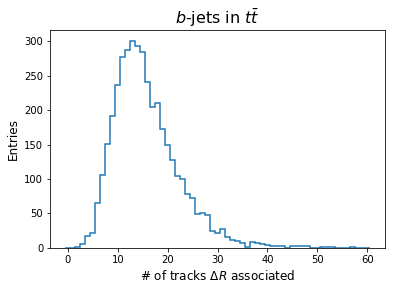

In [22]:
plt.figure()

plt.hist(jet_df.btag_ntrk,61,(-0.5,60.5),histtype='step',linewidth=1.5)
plt.xlabel('# of tracks $\Delta R$ associated',fontsize=12)
plt.ylabel('Entries',fontsize=12)
plt.title(r'$b$-jets in $t\bar{t}$',fontsize=16)
plt.savefig(figDir+'btag_ntrk.pdf')
plt.show()

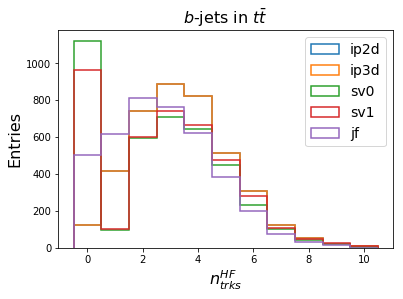

In [38]:
plt.figure()

nBins = 11
myRange = (-0.5,10.5)

for alg in ['ip2d','ip3d','sv0','sv1','jf']:
    
    plt.hist(jet_df['nHF_'+alg],nBins,myRange,label=alg,histtype='step',linewidth=1.5)
    
plt.xlabel('$n_{trks}^{HF}$',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title(r'$b$-jets in $t\bar{t}$',fontsize=16)
plt.legend(fontsize=14)
plt.savefig(figDir+'nHF_algo.pdf')
plt.show()

**Note:** ip2d and ip3d have the same track selections.

In [12]:
np.min(jet_df['nHF_ip2d']-jet_df['nHF_ip3d']),np.max(jet_df['nHF_ip2d']-jet_df['nHF_ip3d'])

(0.0, 0.0)

I thought it was interesting that sv0 and sv1 had different track selections, but I guess it doesn't really matter because sv0 is a defunct alg anyways.

## Let's compare the HF track distributions

It would probably be a good idea to compare the the HF tracks kept by *all* the algorithms.

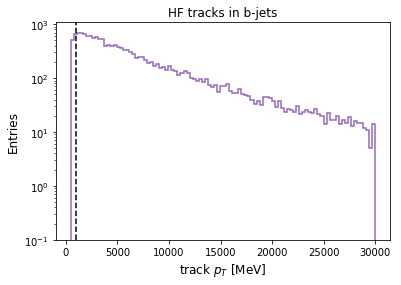

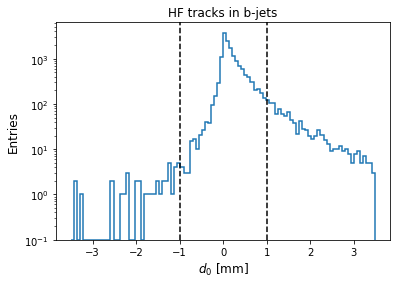

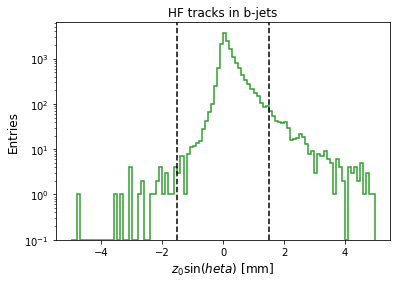

In [37]:
for ti,r,l,xlabel,c in zip(['jet_trk_pt','jet_trk_ip3d_d0','jet_trk_ip3d_z0'],
                         [(500,30000),(-3.5,3.5),(-5,5)],[1000,1,1.5],
                         ['track $p_T$ [MeV]', '$d_0$ [mm]', '$z_0 \sin ( \theta )$ [mm]'],['C4','C0','C2']):

    plt.hist(np.concatenate(output_trk_array[ti]),100,r,log=True,
             color=c,histtype='step',linewidth=1.5)
    
    ylim = plt.ylim()
    plt.plot([l]*2,ylim,'k--')
    if 'ip3d' in ti:
        plt.plot([-l]*2,ylim,'k--')
    plt.ylim(ylim)
    
    plt.ylabel('Entries',fontsize=12)
    plt.xlabel(xlabel,fontsize=12)
    plt.title('HF tracks in b-jets')
    plt.savefig(figDir+ti+'.pdf')
    plt.show()

And maybe it would be useful to also plot the 2d distribution between ip2d and ip3d?

Or the correlation with b-hadron $L_{xy}$?

In [33]:
from matplotlib.colors import LogNorm

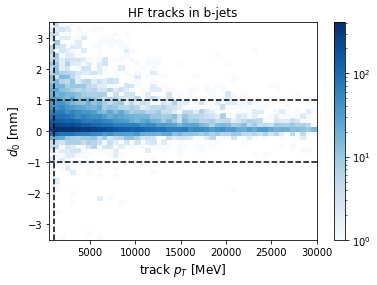

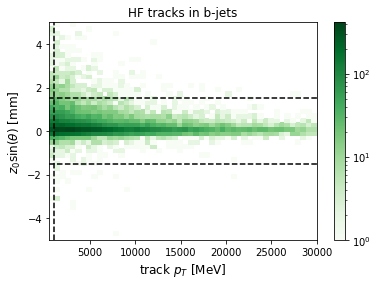

In [42]:
pts = np.concatenate(output_trk_array['jet_trk_pt'])
rpt = (500,30000)

for ti,r,l,ylabel,cmap in zip(['jet_trk_ip3d_d0','jet_trk_ip3d_z0'],
                         [(-3.5,3.5),(-5,5)],[1,1.5],
                         [ '$d_0$ [mm]', r'$z_0 \sin ( \theta )$ [mm]'],['Blues','Greens']):

    plt.hist2d(pts,np.concatenate(output_trk_array[ti]),50,(rpt,r),cmap=cmap,norm=LogNorm())
    
    xlim = plt.xlim()
    plt.plot(xlim,[l]*2,'k--')
    plt.plot(xlim,[-l]*2,'k--')
    plt.xlim(xlim)
    
    ylim = plt.ylim()
    plt.plot([1000]*2,ylim,'k--')
    plt.ylim(ylim)
    
    plt.xlabel('track $p_T$ [MeV]',fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    
    plt.colorbar()
    
    plt.title('HF tracks in b-jets')
    plt.savefig(figDir+ti+'_jet_trk_pt.pdf')
    plt.show()

**Question:** How many HF tracks would you keep in $b$-jets if you apply these cuts?

In [43]:
hf_pts = np.concatenate(output_trk_array['jet_trk_pt'])
hf_d0s = np.concatenate(output_trk_array['jet_trk_ip3d_d0'])
hf_z0s = np.concatenate(output_trk_array['jet_trk_ip3d_z0'])

In [44]:
jf_mask = (hf_pts > 500) & (np.abs(hf_d0s) < 3.5) & (np.abs(hf_z0s) < 5)

In [45]:
np.sum(jf_mask) / len(jf_mask)

0.9891774891774892

In [46]:
ip3d_mask = (hf_pts > 1000) & (np.abs(hf_d0s) < 1) & (np.abs(hf_z0s) < 1.5)

In [47]:
np.sum(ip3d_mask) / len(ip3d_mask)

0.8604205318491033

Maybe I should double check some of the track quality variables when I apply these cuts?

For each of the low-level algos, can we calculate the min and max $d_0$, $z_0 \sin (\theta)$ and $p_T$?

It would be a good idea to sanity check that what I'm doing makes sense on some level.

In [48]:
for alg in ['sv1','jf']:
    
    print("\n"+alg+":")
    
    for var in ['ip3d_d0','ip3d_z0','d0','z0','pt']:
        
        key = 'jet_trk_'+var+'_'+alg
        val = np.concatenate(output_trk_array[key])
        
        print("  {}: min = {}, max = {}".format(var, np.min(val), np.max(val)))
        


sv1:
  ip3d_d0: min = -4.647597312927246, max = 4.832143783569336
  ip3d_z0: min = -21.5918025970459, max = 23.786052703857422
  d0: min = -4.766695499420166, max = 4.841298580169678
  z0: min = -67.07494354248047, max = 81.72542572021484
  pt: min = 700.4512329101562, max = 125465.3671875

jf:
  ip3d_d0: min = -3.3642044067382812, max = 3.4854354858398438
  ip3d_z0: min = -4.749642848968506, max = 4.942856788635254
  d0: min = -3.491091251373291, max = 3.3955633640289307
  z0: min = -20.41650390625, max = 28.290786743164062
  pt: min = 501.5301208496094, max = 684256.125


In [49]:
for alg in ['sv1','jf']:
    
    print("\n"+alg+":")
    
    for var in ['ip3d_d0','ip3d_z0','pt']:
        
        key = 'jet_trk_'+var+'_'+alg
        val = np.concatenate(output_trk_array[key])
        
        print("  {}: min = {}, max = {}".format(var, np.min(val), np.max(val)))
        


sv1:
  ip3d_d0: min = -4.647597312927246, max = 4.832143783569336
  ip3d_z0: min = -21.5918025970459, max = 23.786052703857422
  pt: min = 700.4512329101562, max = 125465.3671875

jf:
  ip3d_d0: min = -3.3642044067382812, max = 3.4854354858398438
  ip3d_z0: min = -4.749642848968506, max = 4.942856788635254
  pt: min = 501.5301208496094, max = 684256.125


In [50]:
output_trk_array.keys()

dict_keys(['jet_trk_ip3d_d0sig', 'jet_trk_ip3d_z0sig', 'jet_trk_ip3d_d0', 'jet_trk_ip3d_z0', 'jet_trk_ip3d_grade', 'jet_trk_algo', 'jet_trk_pt', 'jet_trk_eta', 'jet_trk_theta', 'jet_trk_phi', 'jet_trk_orig', 'jet_trk_nInnHits', 'jet_trk_nsharedBLHits', 'jet_trk_nsplitBLHits', 'jet_trk_nNextToInnHits', 'jet_trk_nPixHits', 'jet_trk_nPixHoles', 'jet_trk_nsharedPixHits', 'jet_trk_nsplitPixHits', 'jet_trk_nSCTHits', 'jet_trk_nSCTHoles', 'jet_trk_nsharedSCTHits', 'jet_trk_ptfrac', 'jet_trk_dr', 'jet_trk_ip3d_d0_sv1', 'jet_trk_ip3d_z0_sv1', 'jet_trk_d0_sv1', 'jet_trk_z0_sv1', 'jet_trk_pt_sv1', 'jet_trk_ip3d_d0_jf', 'jet_trk_ip3d_z0_jf', 'jet_trk_d0_jf', 'jet_trk_z0_jf', 'jet_trk_pt_jf'])